In [1]:
import pywt
# (cA, cD) = pywt.dwt([1, 2, 3, 4, 5, 6], 'db1')
# ([2.12132034 4.94974747 7.77817459], [-0.70710678 -0.70710678 -0.70710678])
# https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from matplotlib import style
# style.use('ggplot')

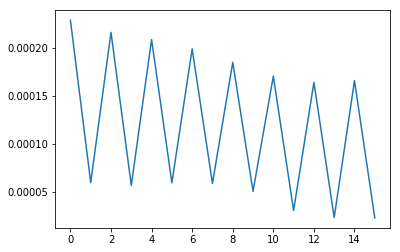

In [16]:
df = pd.read_csv("filtered_chocolate/0.csv", usecols=['ch0', 'ch1', 'ch2', 'ch3'])
# print(df.loc[0:14])
# print(df.loc[15:29])
# df = df.loc[0:15].div(0.00001)
# arr = np.array(df['ch0'].tolist())
# arr = np.append(arr, np.array(df['ch1'].tolist()))
# arr = np.append(arr, np.array(df['ch2'].tolist()))
# arr = np.append(arr, np.array(df['ch3'].tolist()))
# print(type(arr), "arr = ", arr)
# N = 15
# sg, _, _, _ = plt.specgram(arr, NFFT=N, noverlap=N//2, Fs=100)
# sg = sg.flatten()

# print("sg = ", sg)
# print(type(sg))
# print(raw(df.loc[0:14]).shape)
# print(specgram(df.loc[0:14]).shape)
# getFeature(df.loc[0:14])

# df = pd.read_csv("filtered_chocolate/0.csv", usecols=['ch0', 'ch1', 'ch2', 'ch3'])
# sg = specgram(df.loc[0:15])
# print(sg)

df = df.loc[0:14] #.reset_index(drop=True)
# plt.plot(df)
wt = dwt(df)
plt.plot(wt)
plt.show()
# df = pd.read_csv("filtered_pasta/0.csv", usecols=['ch0', 'ch1', 'ch2', 'ch3'])
# arr = df.loc[0:14].div(0.00001)["ch0"].values
# arr = np.append(arr, arr)
# print(arr)
# # dwt(df.loc[0:14].values)
# print(raw(df.loc[0:14]))

In [3]:
def specgram(segment):
    # featureSize = 56
    samplingFreq = 100
    N = 15
    arr = np.array(segment['ch0'].tolist())
    arr = np.append(arr, np.array(segment['ch1'].tolist()))
    arr = np.append(arr, np.array(segment['ch2'].tolist()))
    arr = np.append(arr, np.array(segment['ch3'].tolist()))
    sg, _, _, _ = plt.specgram(arr, NFFT=N, noverlap=N//2, Fs=samplingFreq)
    return sg.flatten()

def wt(segment):
    # featureSize = 8
    return pywt.wavedec(segment["ch0"], 'db1', level=3)[2]

def dwt(segment):
    # featureSize = 16
    coeffs = pywt.dwt2(segment.values, 'haar')
    cA, (cH, cV, cD) = coeffs
    res = cA.flatten()
    return res

def raw(segment):
    # featureSize = 4 * batchSize
    res = segment["ch0"].values
    res = np.append(res, segment["ch1"].values)
    res = np.append(res, segment["ch2"].values)
    res = np.append(res, segment["ch3"].values)
    return res

featureSize = 76
def getFeature(segment):
    segment = segment.div(0.00001)
    res = raw(segment) # +60
    res = np.append(res, dwt(segment)) # +16
    # res = np.append(res, specgram(segment)) # +48
    return res

def featuresFromFile(fileName, fileNum):
    global featureSize
    batch = 15
    df = pd.read_csv("filtered_" + fileName + "/" + str(fileNum) + ".csv", usecols=['ch0', 'ch1', 'ch2', 'ch3'])
    pickups = np.empty(shape=[0,featureSize])
    putdowns = np.empty(shape=[0,featureSize])

    rows = df.shape[0]
    turns = rows / batch
    turns -= turns % 2
    rows = turns * batch
    r = 0
    while r < rows:
        # pick-up
        pickups = np.vstack((pickups, getFeature(df.loc[r:r+batch-1])))
        r += batch
        # put-down
        putdowns = np.vstack((putdowns, getFeature(df.loc[r:r+batch-1])))
        r += batch
    return (pickups, putdowns)

def labelFeatures(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels, fileName, fileNum, label):
    (pickups, putdowns) = featuresFromFile(fileName, fileNum)
    # register features
    pickupFeatures = np.vstack((pickupFeatures, pickups))
    putdownFeatures = np.vstack((putdownFeatures, putdowns))
    # register labels
    pickupLabels = np.vstack((pickupLabels, np.full((pickups.shape[0], 1), label)))
    putdownLabels = np.vstack((putdownLabels, np.full((putdowns.shape[0], 1), label + 1)))
    return (pickupFeatures, pickupLabels, putdownFeatures, putdownLabels)

def trainModels(features, labels):
    # features
    X = features
    # labels
    y = labels.flatten()
    clf = svm.SVC(C=1, kernel='poly', coef0=1.0, probability=True, tol=1e-5)
    clf.fit(X, y)
    return clf

# def predict(pickupModel, putdownModel, fileName, fileRange, answerLabel):
#     pickupResult = np.array([], dtype=int)
#     putdownResult = np.array([], dtype=int)
#     pickupCorrect = 0
#     putdownCorrect = 0
#     for fileNum in fileRange:
#         (pickups, putdowns) = featuresFromFile(fileName, fileNum)
#         pickupResult = np.append(pickupResult, pickupModel.predict(pickups))
#         putdownResult = np.append(putdownResult, putdownModel.predict(putdowns))
#     for label in pickupResult:
#         if label == answerLabel:
#             pickupCorrect += 1
#     for label in putdownResult:
#             if label == (answerLabel + 1):
#                 putdownCorrect += 1
#     print(pickupResult)
#     print(putdownResult)
#     print("{0:.2f}".format(100.0 * pickupCorrect / pickupResult.size) + '%')
#     print("{0:.2f}".format(100.0 * putdownCorrect / putdownResult.size) + '%')

def loadData(totalFiles):
    pickupFeatures = np.empty(shape=[0, featureSize])
    pickupLabels = np.empty(shape=[0, 1],dtype=int)
    putdownFeatures = np.empty(shape=[0, featureSize])
    putdownLabels = np.empty(shape=[0, 1],dtype=int)
    for fileNum in range(totalFiles):
        (pickupFeatures, pickupLabels, putdownFeatures, putdownLabels) = labelFeatures(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels, "chocolate", fileNum, 1)
        (pickupFeatures, pickupLabels, putdownFeatures, putdownLabels) = labelFeatures(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels, "peach", fileNum, 3)
        (pickupFeatures, pickupLabels, putdownFeatures, putdownLabels) = labelFeatures(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels, "pasta", fileNum, 5)
    return (pickupFeatures, pickupLabels.flatten(), putdownFeatures, putdownLabels.flatten())
    


In [285]:
(pickupFeatures, pickupLabels, putdownFeatures, putdownLabels) = loadData(16)

In [286]:
pickupFeatures.shape

(495, 76)

In [282]:
test_size = 0.2
Pickup_train, Pickup_test, PickupLabel_train, PickupLabel_test = sk.model_selection.train_test_split(pickupFeatures, pickupLabels, test_size=test_size)
Putdown_train, Putdown_test, PutdownLabel_train, PutdownLabel_test = sk.model_selection.train_test_split(putdownFeatures, putdownLabels, test_size=test_size)

PickupModel = trainModels(Pickup_train, PickupLabel_train)
PutdownModel = trainModels(Putdown_train, PutdownLabel_train)

PickupPredict = PickupModel.predict(Pickup_test)
PutdownPredict = PutdownModel.predict(Putdown_test)

PickupAccuracy = (PickupLabel_test.reshape(-1) == PickupPredict).sum() / PickupLabel_test.shape[0]
PutdownAccuracy = (PutdownLabel_test.reshape(-1) == PutdownPredict).sum() / PutdownLabel_test.shape[0]

# print(sk.metrics.confusion_matrix(PickupLabel_test, PickupPredict))  
print(sk.metrics.classification_report(PickupLabel_test, PickupPredict), "  total avg      ", PickupAccuracy)
print("--------------------------------------------------------------")
# print(sk.metrics.confusion_matrix(PutdownLabel_test, PutdownPredict))  
print(sk.metrics.classification_report(PutdownLabel_test, PutdownPredict), " total avg       ", PutdownAccuracy)

              precision    recall  f1-score   support

           1       0.88      0.84      0.86        25
           5       0.90      0.92      0.91        38

   micro avg       0.89      0.89      0.89        63
   macro avg       0.89      0.88      0.88        63
weighted avg       0.89      0.89      0.89        63
   total avg       0.8888888888888888
--------------------------------------------------------------
              precision    recall  f1-score   support

           2       0.88      0.91      0.89        23
           6       0.95      0.93      0.94        40

   micro avg       0.92      0.92      0.92        63
   macro avg       0.91      0.92      0.92        63
weighted avg       0.92      0.92      0.92        63
  total avg        0.9206349206349206


/Users/allenh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/allenh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [179]:
# 1: pick up chocolate
# 2: put down chocolate
# 3: pick up peach
# 4: put down peach
# 5: pick up pasta
# 6: put down pasta

#               precision    recall  f1-score   support
# 
#            1       0.64      0.72      0.67        39
#            3       0.81      0.66      0.73        59
#            5       0.82      0.92      0.87        51

#    micro avg       0.77      0.77      0.77       149
#    macro avg       0.76      0.77      0.76       149
# weighted avg       0.77      0.77      0.76       149
#    total avg       0.7651006711409396
# --------------------------------------------------------------
#               precision    recall  f1-score   support

#            2       0.60      0.63      0.61        43
#            4       0.70      0.72      0.71        46
#            6       0.88      0.83      0.85        60

#    micro avg       0.74      0.74      0.74       149
#    macro avg       0.73      0.73      0.73       149
# weighted avg       0.74      0.74      0.74       149
#   total avg        0.738255033557047